In [1]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
# candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400
historyData = polo.returnChartData(currencyPair="BTC_XRP",
                     start=string2ts("2017-03-01 00:00:00"),
                     end=string2ts("2017-06-01 10:00:00"),
                     period=3600*24)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-03-01,0.000004,4.72e-6,0.000005,0.000005,125406329.81283,564.066569,4.49e-6
2017-03-02,0.000005,5.19e-6,0.000005,0.000004,298415235.57586,1417.800486,4.75e-6
2017-03-03,0.000005,5.14e-6,0.000005,0.000005,182511394.48331,895.120464,4.9e-6
2017-03-04,0.000005,5.25e-6,0.000005,0.000005,108724105.08221,547.815586,5.03e-6
2017-03-05,0.000005,5.02e-6,0.000005,0.000005,74147272.169513,358.000394,4.82e-6


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: 3087.35632184


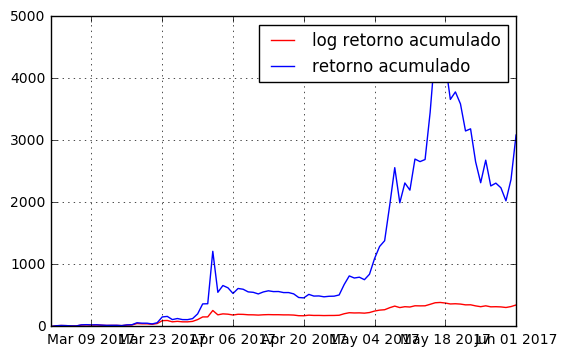

In [2]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1).fillna(0)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff().fillna(0)

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
#df.isnull().any()
#df[df['retornos relativos'].isnull()]
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

El retorno relativo con la estrategia EMA5 VS SMA20 fue: 1968.44036697
5.45e-06
              w orders     price  price_profit      return
date                                                      
2017-03-01  0.0   WAIT  0.000004      0.000000    0.000000
2017-03-02  0.0   WAIT  0.000005      0.000000    0.000000
2017-03-03  0.0   WAIT  0.000005      0.000000    0.000000
2017-03-04  0.0   WAIT  0.000005      0.000000    0.000000
2017-03-05  0.0   WAIT  0.000005      0.000000    0.000000
2017-03-06  0.0   WAIT  0.000005      0.000000    0.000000
2017-03-07  1.0    BUY  0.000005     -0.000005 -100.000000
2017-03-08  1.0   WAIT  0.000006      0.000000 -100.000000
2017-03-09  1.0   WAIT  0.000005      0.000000 -100.000000
2017-03-10  1.0   WAIT  0.000006      0.000000 -100.000000
2017-03-11  1.0   WAIT  0.000005      0.000000 -100.000000
2017-03-12  1.0   WAIT  0.000005      0.000000 -100.000000
2017-03-13  1.0   WAIT  0.000005      0.000000 -100.000000
2017-03-14  1.0   WAIT  0.000005   

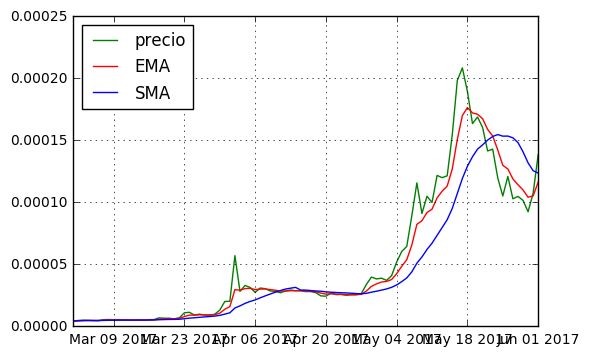

In [3]:
from profit import profit,change5
from orders import orders

# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=13,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = serie.rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = serie.ewm(span=emaPeriod, adjust=False).mean()
    
    # Encontrando el signo de la resta entre ellas para encontrar los cruces
    dif = (ema - sma).apply(np.sign)
    
    w = pd.DataFrame(data={"w":(dif+1)/2})
    
    w['w'] = w['w'].apply(change5)
    
    w["orders"] = orders(w["w"])
    
    w["price"] = serie
    
    plt.plot(df.index,df['close'],'g',label='precio')
    plt.plot(df.index,ema,'r',label='EMA')
    plt.plot(df.index,sma,'b',label='SMA')
    plt.legend(loc='best')
    plt.grid()
    
    return w



w = estrategiaEMAvsSMA(df['close'])
relativeReturn, vecReturn = profit(w)

#plt.plot(df.index,vecReturn,'g',label='retorno')


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)
# Creando nueva columna con los precios
w["price_profit"] = w["price"]
# para la fila en que orders es BUY el precio será negativo
w.loc[w["orders"] == "BUY","price_profit"] = w[w["orders"] == "BUY"]["price"]*-1
# para la fila en que orders es WAIT el preico será 0
w.loc[w["orders"] == "WAIT","price_profit"] = 0
# se restan todos los precios de compra de los precios de venta y se divide entre el primer precio de compra
w["return"] = (w["price_profit"].cumsum()/w[w["orders"] == "BUY"]["price"][0])*100
print w[w["orders"] == "BUY"]["price"][0]
print w.head(50)

## Probando otras versiones de la estrategia de cruce de medias

El mejor desempeño en las estrategias de medias moviles para el par XRP_BTC entre 1/06/2017 y el 1/09/2017 con precio de un día, lo obtuvo price vs EMA_5, con un profit de 239.78%. El mercado en cambio tuvo un profit de -62.77% en el mismo periodo.
<br>
***Intervalo precio, profit price vs EMA_5, profit market*** 
<br>
* 1d, 239.78%, -62.77%
* 4h, 2.937%, -53.9%
* 2h, 17.655.12%, -55.11%
* 30m, 12'202.905%, -49.58% 

In [4]:
from strategy import pricevsEMA, pricevsSMA, EMAvsEMA

#Precio vs EMA_5

w = pricevsEMA(df["close"])
relativeReturn,v = profit(w)

w["price_profit"] = w["price"]
w.loc[w["orders"] == "BUY","price_profit"] = w[w["orders"] == "BUY"]["price"]*-1
w.loc[w["orders"] == "WAIT","price_profit"] = 0

print (w["price_profit"].sum()/w[w["orders"] == "BUY"]["price"][0])*100

print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)

852.272727273
El retorno relativo con la estrategia EMA5 VS SMA20 fue: 852.272727273


El retorno relativo con la estrategia EMA5 VS SMA20 fue: -649.173553719


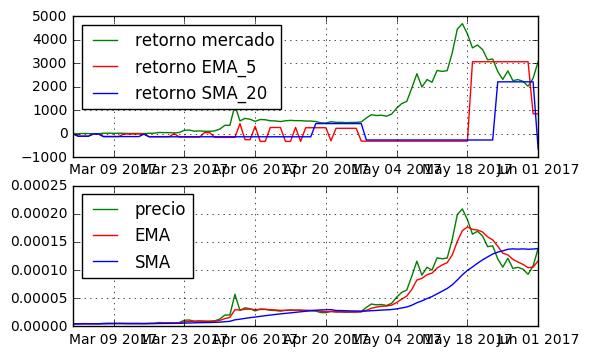

In [5]:
#Precio vs SMA_20

w2 = pricevsSMA(df["close"])
relativeReturn,v2 = profit(w2)

# Calculando media movil a 20 muestras
sma = df["close"].rolling(20,min_periods=1).mean()
# caculando exponential movil average
ema = df["close"].ewm(span=5, adjust=False).mean()

plt.subplot(211)
plt.plot(df.index,df['cum_r']*100,'g', label='retorno mercado')
plt.plot(df.index,v*100,'r',label='retorno EMA_5')
plt.plot(df.index,v2*100,'b',label='retorno SMA_20')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,df['close'],'g',label='precio')
plt.plot(df.index,ema,'r',label='EMA')
plt.plot(df.index,sma,'b',label='SMA')
plt.legend(loc='best')
plt.grid()


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)

In [6]:
#EMA_5 vs EMA_20

w = EMAvsEMA(df["close"])
relativeReturn,v = profit(w)

print 'El retorno relativo con la estrategia EMA5 VS EMA20 fue: %s'%(relativeReturn*100)

El retorno relativo con la estrategia EMA5 VS EMA20 fue: 2007.43801653
